# Model Notebook

This notebook contains the last of my work towards our final model.

In [881]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report

# Ensemble/XGBoost
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

#.py file
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import src.mc_functions as mcf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [931]:
# import base dataframe
df = mcf.create_base_df()

In [932]:
long_index = df[df['longitude'] == 0].index

In [933]:
df = df.drop(long_index, axis=0)

In [934]:
df.drop(['latitude', 'longitude'], axis=1, inplace=True)

In [935]:
df.shape

(57588, 20)

My group decided the rows with a longitude of 0 should be dropped. Now I can split the data and get right to modeling

In [936]:
# target
y = df['status_group']
# features
X = df.drop('status_group', axis=1)

In [937]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2)

I need to fill in the missing values for construction_year so I can calculate some sort of age column. I am going to continue doing it the way I have been, using the median construction_year for each basin. It may not be entirely accurate, but in the models I was creating it still was at the top of feature importance for the majority.

In [938]:
X_train['construction_year'] = X_train['construction_year'].replace(0, np.nan)

In [939]:
basins = X_train['basin'].unique()
med_year_basin = {}
for basin in basins:
    med_year = X_train[X_train['basin'] == basin].median()['construction_year']
    med_year_basin[basin] = med_year

In [940]:
X_train['construction_year'] = X_train['construction_year'].replace(np.nan, 0)

In [941]:
# fill in missing construction_year in X_train
for idx, row in X_train.iterrows():
    if row['construction_year'] == 0:
        X_train['construction_year'][idx] = med_year_basin[row['basin']]

# fill in missing construction_year in X_test
for idx, row in X_test.iterrows():
    if row['construction_year'] == 0:
        X_test['construction_year'][idx] = med_year_basin[row['basin']]

In [942]:
X_train['age'] = 2020 - X_train['construction_year']
X_test['age'] = 2020 - X_test['construction_year']

Now I can drop construction_year from both dataframes

In [943]:
X_train.drop('construction_year', axis=1, inplace=True)
X_test.drop('construction_year', axis=1, inplace=True)

In [42]:
df['construction_year'] = df['construction_year'].replace(0, np.nan)
df_med_year_basin = {}
for basin in basins:
    med_year = df[df['basin'] == basin].median()['construction_year']
    df_med_year_basin[basin] = med_year

df['construction_year'] = df['construction_year'].replace(np.nan)

# fill in missing construction_year in df
for idx, row in df.iterrows():
    if row['construction_year'] == 0:
        df['construction_year'][idx] = df_med_year_basin[row['basin']]

df['age'] = 2020 - df['construction_year']

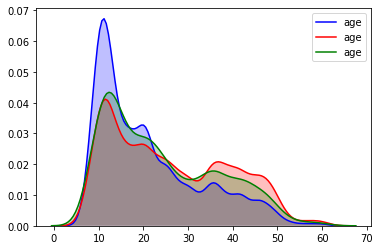

In [43]:
sns.kdeplot(df[df['status_group'] == 'functional']['age'], shade=True, color='blue')
sns.kdeplot(df[df['status_group'] == 'non functional']['age'], shade=True, color='red')
sns.kdeplot(df[df['status_group'] == 'functional needs repair']['age'], shade=True, color='green')


It's pretty clear that the age of the pump as a pretty significant affect on its functionality status. That may be a cool visual for the presentation. Time to get modeling.

### Features 1

In [44]:
X_train.columns

Index(['amount_tsh', 'gps_height', 'installer', 'basin', 'region',
       'population', 'extraction_type_group', 'management_group', 'payment',
       'water_quality', 'quantity', 'source_type', 'waterpoint_type_group',
       'age'],
      dtype='object')

In [66]:
cats = ['management_group', 'waterpoint_type_group', 'payment', 'extraction_type_group', 'source_type']
nums = ['amount_tsh', 'age', 'gps_height']
X_train1, X_test1 = mcf.process_data(X_train, X_test, cats, nums)

In [73]:
dt1 = DecisionTreeClassifier(max_depth=10, min_samples_split=3, max_features=.75)

In [74]:
dt1.fit(X_train1, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=0.75, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [75]:
print(classification_report(y_train, dt1.predict(X_train1)))

precision    recall  f1-score   support

             functional       0.69      0.88      0.77     25088
functional needs repair       0.56      0.09      0.15      3140
         non functional       0.75      0.55      0.64     17842

               accuracy                           0.70     46070
              macro avg       0.66      0.51      0.52     46070
           weighted avg       0.70      0.70      0.68     46070



In [76]:
feature_importance = pd.DataFrame(dt1.feature_importances_,
                                   index = X_train1.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [731]:
impute = SimpleImputer(strategy='most_frequent')
X_train['installer'] = impute.fit_transform(np.array(X_train['installer']).reshape(-1, 1))
X_train['installer_grouped'] = mcf.summarize_variable(X_train, 'installer', 10)

In [732]:
X_test['installer'] = impute.transform(np.array(X_test['installer']).reshape(-1, 1))
X_test['installer_grouped'] = mcf.summarize_variable(X_test, 'installer', 10)

In [743]:
X_train['lga_grouped'] = mcf.summarize_variable(X_train, 'lga', 16)
X_test['lga_grouped'] = mcf.summarize_variable(X_test, 'lga', 16)

In [77]:
feature_importance

,importance
x1_other,0.282367
age,0.172345
amount_tsh,0.129687
gps_height,0.125276
x3_gravity,0.043030
x3_nira/tanira,0.031904
x2_pay monthly,0.019378
x3_other,0.018052
x3_mono,0.017335
x0_commercial,0.016424


In [80]:
X_train['waterpoint_type_group'].value_counts()

communal standpipe    27476
hand pump             12935
other                  4957
improved spring         604
cattle trough            94
dam                       4
Name: waterpoint_type_group, dtype: int64

Waterpoint_type_group doesn't seem to be having much influence on the predictions. Half of it's categories are having no effect on the model so I am going to drop that column

In [600]:
cats = ['basin', 'quantity', 'source_type', 'installer_grouped']
nums = ['amount_tsh', 'age', 'gps_height']
X_train2, X_test2 = mcf.process_data(X_train, X_test, cats, nums)

In [494]:
X_train['management_group'].value_counts()

user-group    40594
commercial     2899
parastatal     1375
other           781
unknown         421
Name: management_group, dtype: int64

In [495]:
dt1.fit(X_train2, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=0.75, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [496]:
print(classification_report(y_train, dt1.predict(X_train2)))

precision    recall  f1-score   support

             functional       0.70      0.90      0.79     25088
functional needs repair       0.61      0.13      0.21      3140
         non functional       0.79      0.59      0.67     17842

               accuracy                           0.73     46070
              macro avg       0.70      0.54      0.56     46070
           weighted avg       0.73      0.73      0.71     46070



In [497]:
dt1.score(X_train2, y_train)

0.728196223138702

About .7 accuracy, not bad. I want to check feature importance again and see what I can add/drop

In [498]:
feature_importance = pd.DataFrame(dt1.feature_importances_,
                                   index = X_train2.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [499]:
feature_importance

,importance
x1_dry,0.260565
x1_enough,0.172379
age,0.137689
gps_height,0.108381
amount_tsh,0.087962
x2_spring,0.031115
x0_Lake Tanganyika,0.023445
x2_river/lake,0.017004
x0_Lake Nyasa,0.015172
x0_Internal,0.013166


Those are the features I am going to use for now. I need to experiment with some different models.

In [335]:
rf1 = RandomForestClassifier(n_estimators=1000)

In [336]:
rf1.fit(X_train2, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='entropy',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [337]:
print(classification_report(y_train, rf1.predict(X_train2)))

precision    recall  f1-score   support

             functional       0.85      0.96      0.91     25088
functional needs repair       0.94      0.59      0.73      3140
         non functional       0.93      0.82      0.87     17842

               accuracy                           0.88     46070
              macro avg       0.91      0.79      0.84     46070
           weighted avg       0.89      0.88      0.88     46070



In [338]:
recall_score(y_train, rf1.predict(X_train2), average='weighted')

0.8834599522465812

In [339]:
recall_score(y_test, rf1.predict(X_test2), average='weighted')

0.7567285987150547

Not bad, training recall of about .9. I want to try XGBoost now

In [623]:
X_train.columns

Index(['amount_tsh', 'gps_height', 'installer', 'basin', 'subvillage',
       'region', 'population', 'extraction_type_group', 'management_group',
       'payment', 'water_quality', 'quantity', 'source_type',
       'waterpoint_type_group', 'age', 'installer_grouped'],
      dtype='object')

In [776]:
X_test['lga_grouped'].value_counts()

lga_other       8832
Njombe           511
Arusha Rural     260
Moshi Rural      259
Kilosa           236
Kasulu           233
Rungwe           216
Kilombero        207
Mbozi            200
Bagamoyo         193
Meru             186
Kibondo          185
Name: lga_grouped, dtype: int64

In [777]:
X_train['lga_grouped'].value_counts()

lga_other        35507
Njombe            1992
Moshi Rural        992
Arusha Rural       992
Rungwe             890
Kilosa             858
Mbozi              834
Meru               823
Kasulu             814
Singida Rural      812
Bagamoyo           804
Kilombero          752
Name: lga_grouped, dtype: int64

In [778]:
X_train['lga_grouped'] = mcf.summarize_variable(X_train, 'lga', 12)
X_test['lga_grouped'] = mcf.summarize_variable(X_test, 'lga', 11)

In [ ]:
'lga','quantity_group','quality_group','management_group','extraction_type','source_type','waterpoint_type'

In [971]:
cats = ['management_group', 'quantity_group', 'source_type', 'lga', 'quality_group', 'extraction_type', 'waterpoint_type']
nums = ['age']
X_train3, X_test3 = mcf.process_data(X_train, X_test, cats, nums)

In [897]:
xgb1 = XGBClassifier(random_state=42, objective = 'multi:softmax', scale_pos_weight=10,
                      num_class = 3, eval_metric = 'merror', learning_rate=.25, max_depth = 12, 
                      max_delta_step=5, reg_alpha=2, reg_lambda=0, n_estimators=50)
# scale_pos_weight

In [972]:
xgb1.fit(X_train3, y_train)

KeyboardInterrupt: 

In [899]:
print(classification_report(y_train, xgb1.predict(X_train3)))
print(classification_report(y_test, xgb1.predict(X_test3)))

precision    recall  f1-score   support

             functional       0.82      0.95      0.88     25088
functional needs repair       0.82      0.38      0.52      3140
         non functional       0.90      0.80      0.85     17842

               accuracy                           0.85     46070
              macro avg       0.85      0.71      0.75     46070
           weighted avg       0.85      0.85      0.84     46070

                         precision    recall  f1-score   support

             functional       0.77      0.91      0.83      6301
functional needs repair       0.57      0.21      0.31       791
         non functional       0.83      0.72      0.77      4426

               accuracy                           0.79     11518
              macro avg       0.72      0.61      0.64     11518
           weighted avg       0.78      0.79      0.77     11518



In [895]:
accuracy_score(y_train, xgb1.predict(X_train3))

0.8765791187323638

In [896]:
accuracy_score(y_test, xgb1.predict(X_test3),)

0.7849453030039938

In [973]:
rf1 = RandomForestClassifier(n_estimators=1000)

In [977]:
X_train3.drop('age', axis=1, inplace=True)
X_test3.drop('age', axis=1, inplace=True)

In [978]:
rf1.fit(X_train3, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [979]:
print(classification_report(y_train, rf1.predict(X_train3)))

precision    recall  f1-score   support

             functional       0.79      0.92      0.85     25088
functional needs repair       0.64      0.27      0.37      3140
         non functional       0.85      0.74      0.79     17842

               accuracy                           0.80     46070
              macro avg       0.76      0.64      0.67     46070
           weighted avg       0.80      0.80      0.79     46070



In [980]:
print(classification_report(y_test, rf1.predict(X_test3)))

precision    recall  f1-score   support

             functional       0.76      0.89      0.82      6301
functional needs repair       0.51      0.20      0.29       791
         non functional       0.81      0.69      0.74      4426

               accuracy                           0.77     11518
              macro avg       0.69      0.59      0.62     11518
           weighted avg       0.76      0.77      0.75     11518

